In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


microsoft_data=pd.read_csv('microsoft.csv')

y=microsoft_data['HasDetections']

microsoft_data.drop(columns='HasDetections',inplace=True)

# code to get the missing value count for each variable
missing_value_percentage_df=pd.DataFrame({'Column_Name':microsoft_data.columns,
                                          'Missing_value_count':microsoft_data.isnull().sum(),
                                          'Missing_value_percentage':microsoft_data.isnull().sum()/microsoft_data.shape[0]*100})

missing_value_percentage_df=missing_value_percentage_df.sort_values(by='Missing_value_percentage',ascending=False)

In [5]:
cols_to_drop=[]

cols_with_missing_values_grt_50=list(missing_value_percentage_df[missing_value_percentage_df['Missing_value_percentage']>50].index)

for col in microsoft_data.columns:
    if microsoft_data[col].nunique()==microsoft_data.shape[0] or microsoft_data[col].nunique()==1:
        cols_to_drop.append(col)
        

columns_to_drop=cols_to_drop+cols_with_missing_values_grt_50

microsoft_data.drop(columns=columns_to_drop,inplace=True)


In [6]:
for col in microsoft_data.columns:
    if col!='Census_SystemVolumeTotalCapacity':
        microsoft_data[col]=microsoft_data[col].astype(object)
        
microsoft_data['Census_SystemVolumeTotalCapacity'].dtype


dtype('float64')

In [7]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(microsoft_data,y,test_size=0.2,random_state=43)

# Filling missing values

for col in X_train.columns:
    if X_train[col].dtype=='object':
        X_train[col]=X_train[col].fillna(X_train[col].mode()[0]).astype(object)
        X_test[col]=X_test[col].fillna(X_train[col].mode()[0]).astype(object)
        
    else:
        X_train[col]=X_train[col].fillna(X_train[col].mean())
        X_test[col]=X_test[col].fillna(X_train[col].mean())

  

In [8]:
from sklearn.preprocessing import LabelEncoder
import numpy as np


class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [9]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoderExt()

for col in X_train.columns:
    if X_train[col].dtype=='object':
        le.fit(X_train[col])
        X_train[col]=le.transform(X_train[col])
        X_test[col]=le.transform(X_test[col])

In [10]:
from sklearn.linear_model import LogisticRegression

logreg=LogisticRegression()

logreg.fit(X_train,y_train)



y_pred=logreg.predict(X_test)



In [11]:
import pickle

pickle.dump(logreg,open('Logistic_Regression.pkl','wb'))

In [12]:
from sklearn.naive_bayes import MultinomialNB,BernoulliNB

mnb=BernoulliNB()
mnb.fit(X_train,y_train)

nb_pred=mnb.predict(X_test)

from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_curve,roc_auc_score

confusion_matrix(y_test,nb_pred)
f1_score(y_test,nb_pred)

0.5398187115571383

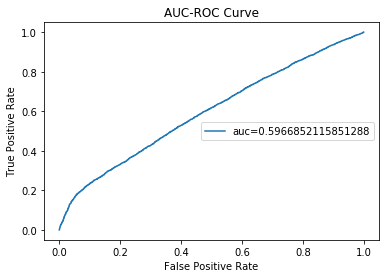

In [13]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]

y_pred_proba

fpr,tpr,thresholds=roc_curve(y_test,y_pred_proba) # the function roc_curve returns three values, the False Positive Rate,True Positive rate
                                                # threshold values it used to calculate the TPR and FPR

auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')

plt.legend(loc=5)
plt.show()

In [14]:
 from sklearn.ensemble import GradientBoostingClassifier
gradient=GradientBoostingClassifier()
gradient.fit(X_train,y_train)
predict=gradient.predict(X_test)
df=pd.DataFrame({'actuals':y_test,'predicts':predict})
df
#predict

,actuals,predicts
13598,0,0
33292,1,0
5740,1,0
9953,0,0
33662,1,1
...,...,...
16471,0,0
52978,1,1
39741,1,1
44074,1,1
